In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numpy import cos, sin, pi, tan

In [48]:
# plane dimensions along x and y axes respectively
a = 10
b = 10

In [49]:
from typing import Optional


MC_SAMPLE_SIZE = 5_000


def line_plane_intersection(
    normal: np.ndarray,
    plane_point: np.ndarray,
    line_dir: np.ndarray,
    line_point: np.ndarray,
) -> Optional[np.ndarray]:
    denominator = np.dot(normal, line_dir)
    if denominator < 1e-15:  # line is parallel to the plane
        return None
    t = np.dot((plane_point - line_point), normal) / denominator
    return line_point + t * line_dir


def effective_area_mc(theta: float, phi: float, d: float) -> tuple[float, float]:
    line_dir = np.array([sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)])
    vertical = np.array([0, 0, 1])
    bottom_plane_point = np.array([0, 0, -d / 2])
    top_plane_point = np.array([0, 0, d / 2])
    # we will use "local" frame with Ox pointing to (theta, phi) direction
    # precalculate transformation from local frame to detector frame
    yaw_rotation = np.array(
        [
            [cos(phi), -sin(phi), 0],
            [sin(phi), cos(phi), 0],
            [0, 0, 1],
        ]
    )
    pitch_angle = theta - pi / 2
    pitch_rotation = np.array(
        [
            [cos(pitch_angle), 0, sin(pitch_angle)],
            [0, 1, 0],
            [-sin(pitch_angle), 0, cos(pitch_angle)],
        ]
    )
    rotation = yaw_rotation @ pitch_rotation

    # using sphere as an enclosing volume, centered at the center of mass of two planes
    # sphere radius is a distance from the center to plane's edge
    sphere_rad = np.sqrt((a / 2) ** 2 + (b / 2) ** 2 + (d / 2) ** 2)
    sphere_cross_section = pi * sphere_rad**2

    n_geom = 0

    for _ in range(MC_SAMPLE_SIZE):
        local_phi = 2 * pi * np.random.random()
        local_rad = sphere_rad * np.sqrt(np.random.random())
        # vector "local" system in which Ox point to (theta, phi) direction
        # note that we swap x <-> z w.r.t standard cylindrical 3d system with Oz axis
        local_r = np.array([0, local_rad * sin(local_phi), local_rad * cos(local_phi)])
        r = rotation @ local_r
        if all(
            intersection is not None
            and (np.abs(intersection[0]) < a / 2 and np.abs(intersection[1]) < b / 2)
            for intersection in [
                line_plane_intersection(
                    normal=vertical,
                    plane_point=bottom_plane_point,
                    line_dir=line_dir,
                    line_point=r,
                ),
                line_plane_intersection(
                    normal=vertical,
                    plane_point=top_plane_point,
                    line_dir=line_dir,
                    line_point=r,
                ),
            ]
        ):
            n_geom += 1

    n_geom_error = np.sqrt(n_geom)
    return (
        sphere_cross_section * n_geom / MC_SAMPLE_SIZE,
        sphere_cross_section * n_geom_error / MC_SAMPLE_SIZE,
    )

In [50]:
def effective_area_geom(theta: float, phi: float, d: float) -> float:
    phi_1q = phi  # reflecting all phi into 1st quadrant
    if pi / 2 <= phi < pi:
        phi_1q = pi - phi
    elif pi <= phi < 3 * pi / 2:
        phi_1q = phi - pi
    elif 3 * pi / 2 < phi < 2 * pi:
        phi_1q = 2 * pi - phi

    x_proj = d * tan(theta) * cos(phi_1q)
    if x_proj > a:
        return 0
    y_proj = d * tan(theta) * sin(phi_1q)
    if y_proj > b:
        return 0
    return (a - x_proj) * (b - y_proj) * cos(theta)

# Zenith dependence

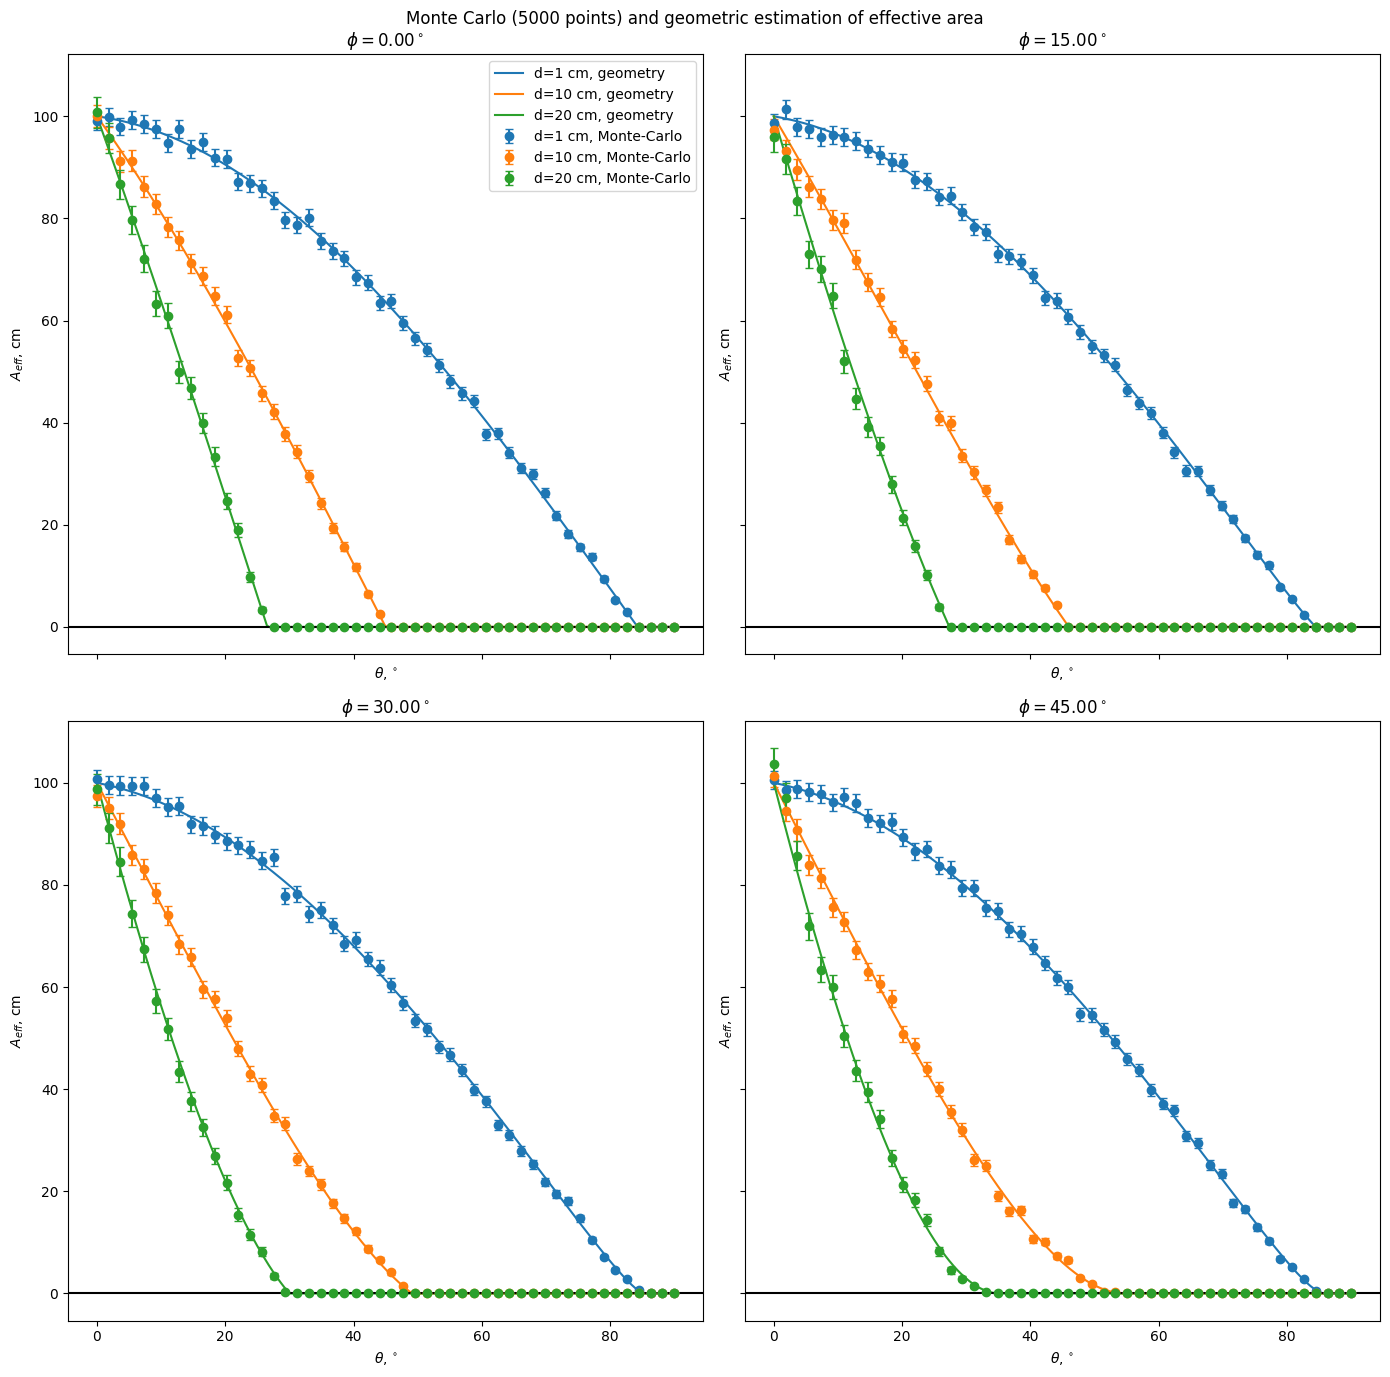

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14, 14))

phi_max = pi / 4
theta_max = pi / 2
cmap = matplotlib.colormaps["tab10"]

for idx, ax in enumerate(axes.flatten()):
    for d_idx, d in enumerate([1, 10, 20]):
        phi = idx * phi_max / (axes.size - 1)
        theta_mc = np.linspace(0, theta_max, 50)
        A_mc_err_pairs = [effective_area_mc(theta, phi, d) for theta in theta_mc]
        A_mc = [A for A, _ in A_mc_err_pairs]
        A_err = [err for _, err in A_mc_err_pairs]
        ax.errorbar(
            180 * theta_mc / pi,
            A_mc,
            A_err,
            marker="o",
            linestyle="none",
            capsize=3,
            color=cmap(d_idx),
            label=f"d={d} cm, Monte-Carlo",
        )

        theta_geom = np.linspace(0, theta_max, 300)
        A_geom = [effective_area_geom(theta, phi, d) for theta in theta_geom]
        ax.plot(180 * theta_geom / pi, A_geom, color=cmap(d_idx), label=f"d={d} cm, geometry")

    ax.axhline(0, color="black")

    ax.set_xlabel("$ \\theta, ^\circ $")
    ax.set_ylabel("$ A_{eff} $, cm")
    ax.set_title(f"$ \\phi = {180 * phi / pi:.2f}^\circ $")
    if idx == 0:
        ax.legend()

fig.suptitle(f"Monte Carlo ({MC_SAMPLE_SIZE} points) and geometric estimation of effective area")
fig.tight_layout()
plt.show()

# Azimuthal dependence

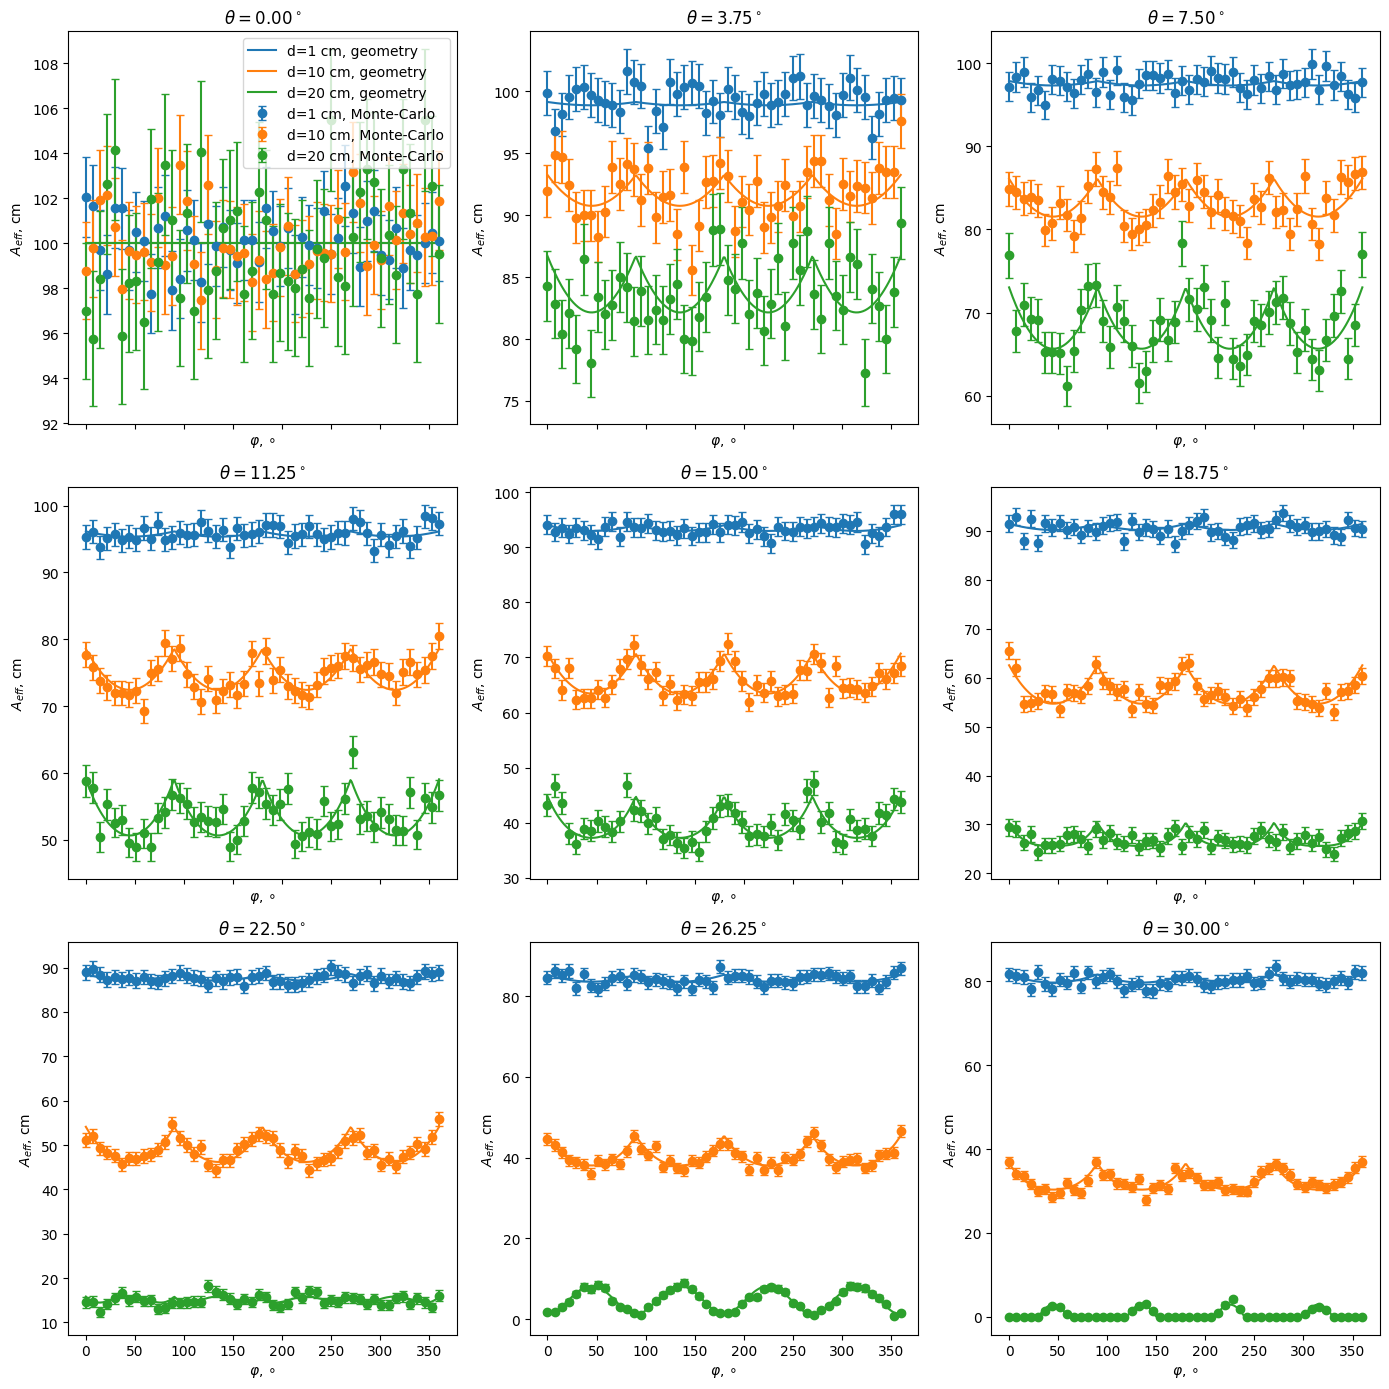

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(14, 14))

theta_max = pi / 6

for idx, ax in enumerate(axes.flatten()):
    for d_idx, d in enumerate([1, 10, 20]):
        theta = idx * theta_max / (axes.size - 1)
        phis_mc = np.linspace(0, 2 * pi, 50)
        A_mc_err_pairs = [effective_area_mc(theta, phi, d) for phi in phis_mc]
        A_mc = [A for A, _ in A_mc_err_pairs]
        A_err = [err for _, err in A_mc_err_pairs]
        ax.errorbar(
            180 * phis_mc / pi,
            A_mc,
            A_err,
            marker="o",
            linestyle="none",
            capsize=3,
            color=cmap(d_idx),
            label=f"d={d} cm, Monte-Carlo",
        )

        phis_geom = np.linspace(0, 2 * pi, 300)
        A_geom = [effective_area_geom(theta, phi, d) for phi in phis_geom]
        ax.plot(180 * phis_geom / pi, A_geom, color=cmap(d_idx), label=f"d={d} cm, geometry")

    ax.set_xlabel("$ \\varphi, \\circ $")
    ax.set_ylabel("$ A_{eff} $, cm")
    ax.set_title(f"$ \\theta = {180 * theta / pi:.2f}^\circ $")
    if idx == 0:
        ax.legend()

fig.tight_layout()
plt.show()